# First Practical work

* Name Student 1: Javier Alzuaz Villegas
* NIA Student 1: 100496335
* Name Student 2: Enrique Velázquez Caballero
* NIA Student 2: 100496427
  
This is second practical work skeleton.

It is divided in 3 parts_

1.   Python module load section: load all the needed modules
2.   Google Drive access and mounting
3.   Host load data






## Module load section
We will install the pycuda module in the colaboratory environment, to combine python and CUDA in our code. Because pycuda is not available by default, this task can take a few minutes.

As well we load numpy and matplotlib modules.

In [2]:
!pip install nibabel

We import the Python modules which we will use in the notebook (numpy, pycuda and time module) 

In [3]:
import  numpy  as  np
from sys import getsizeof
import time
from os.path import join

In [4]:
%matplotlib inline
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cProfile

In [5]:
import nibabel as nib

In [38]:
# import your_library here

import importlib, myneededfunctions as mylib
importlib.reload(mylib)

from myneededfunctions import deal_boundary, init_worker, process_z_slab, build_z_tasks


# Three-dimensional filtering

The objective of the practice is to implement a three-dimensional filtering of information (usually a 3-dimensional image coming from, for example, medical images) to which a preprocessing must be performed for further analysis.

Due to technical limitations, we will assume that the filtering function is a cube of 3x3 voxels (or three-dimensional pixel) and the image will have a maximum size of 1Gbyte (1024x1024x1024), although it will not necessarily be cubic.

## How to filter a voxel?
To filter a voxel we select the coordinates of the voxel we want to filter and the surrounding neighbors in the 3 dimensions (for a 3x3 filter the coefficient corresponding to the voxel to be filtered corresponds to the positions (1,1,1) of the filter mask).
The n selected neighbors are multiplied by the corresponding coefficients in the filter mask, around the selected voxel, and the products are summed, as in the case of 2-dimensional filters.

The result of this sum is the value assigned to the selected position of the resulting voxel.

## Cases at the edges
To calculate the filtered voxel at a position corresponding to one of the edges of the image, we replicate that layer, so that the data of the missing layer is equal to that of the layer to be filtered.
In the case of edges or corners, the value of the corresponding corner is replicated.

## Clapping
The resulting data will be an floating point 32bits data.

## Mount Google Drive and access grant
This part could be used to access to your Google Drive Data, **ONLY IF YOU ARE USING GOOGLE COLABORATORY**. Otherwise leave commented out. 

For security and privacy reasons, this permission is temporally, and will be requested every time you restart the notebook. 

Your Google Drive will be mounted in the "/content/drive" folder. The first Folder will be "My Drive".

You have to copy your images to a folder in the "My Drive" folder in your Google Drive.

To check your available files, use the cell indicated as "**List Files in Folder**"

In [ ]:
# 
# from google.colab import drive
# drive.mount("/content/drive")

In [ ]:
# !ls /content/drive/My\ Drive/images

## IMAGES DEFINITION

The follow MYDRIVE variable will be used to address where are stored the images files.

Please, change it to your correct location.

All the images should be refered to this directory.

In [7]:
MYDRIVE="./"

We define a variable IMAGE which is constructed joining the "MYDRIVE" varible plus the final path to your image.

In [ ]:
#IMAGE=join(MYDRIVE,HERE YOU HAVE TO WRITE THE IMAGE TO LOAD)

In [9]:
EPI_IMAGE = join(MYDRIVE, "someones_epi.nii.gz")

In [10]:
print("Image to load: {0}".format(EPI_IMAGE))

Image to load: ./someones_epi.nii.gz


Loads an image in a numpy variable, and show.

In [11]:
epi_img = nib.load(EPI_IMAGE)
epi_img_data = epi_img.get_fdata().astype(np.float32)

In [12]:
epi_img_data_final = epi_img_data.T


In [13]:
epi_img_data_final.shape

(33, 61, 53)

In [14]:
epi_img_data.dtype

dtype('float32')

Text(0.5, 0.98, 'Center slices for EPI image')

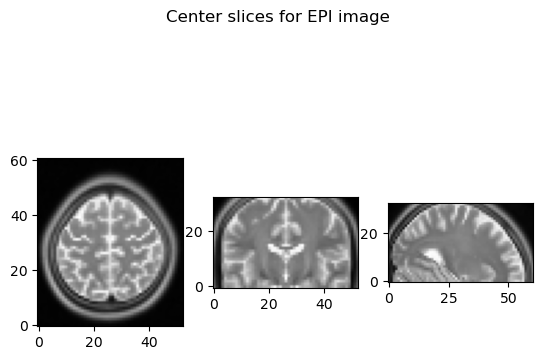

In [15]:
import matplotlib.pyplot as plt

def show_slices(slices):

   """ Function to display row of image slices """

   fig, axes = plt.subplots(1, len(slices))

   for i, slice in enumerate(slices):

       axes[i].imshow(slice, cmap="gray", origin="lower")


slice_0 = epi_img_data_final[26, :, :]
slice_1 = epi_img_data_final[:, 30, :]
slice_2 = epi_img_data_final[:, :, 16]

show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for EPI image")

## FILTERS DEFINITION

Here we defines our sample filter masks.

In [16]:
#This is an identity filter: the resulting
filter1=np.zeros((3,3,3),dtype=np.float32)
filter1[1,1,1] =1.0

In [17]:
#This is an edge detector filter in xy axis filter: the resulting
filter2=np.zeros((3,3,3),dtype=np.float32)
filter2[0,0,1] = -0.25
filter2[2,0,1] = -0.25
filter2[0,2,1] = 0.25
filter2[2,2,1] = 0.25

In [18]:
#This is an edge detector filter in xz axis: the resulting
filter3=np.zeros((3,3,3),dtype=np.float32)
filter3[0,1,0] = -0.25
filter3[2,1,0] = -0.25
filter3[0,1,2] = 0.25
filter3[2,1,2] = 0.25

# YOUR CODE

## SETUP EXPERIMENT

Recover the image shape, and select the two first items (rows and columns).

In [19]:
import numpy as np
import multiprocessing as mp
from multiprocessing.sharedctypes import RawArray
import ctypes
import math
import time

image_shape=epi_img_data_final.shape
Z, Y, X = epi_img_data_final.shape

Creation of shared memory

In [ ]:
num_elements = Z * Y * X

# We create the shared memory buffer for the output image. As we are using independent z-slices, no locks are needed
filtered_image_shm = RawArray(ctypes.c_float, num_elements)

# This creates a numpy view onto the shared buffer; with this, we can easily manipulate it as a 3D array
filtered_image = np.ctypeslib.as_array(filtered_image_shm)
filtered_image = filtered_image.reshape((Z, Y, X))

Task Builder

In [ ]:
def run_filter(kernel, num_workers=None, chunks_per_worker=3):
    # We run the 3D filter using multiprocessing over Z-slices. The function returns the duration of the process
    if num_workers is None:
        num_workers = mp.cpu_count()

    tasks = mylib.build_z_tasks(Z, num_workers, chunks_per_worker)

    t0 = time.perf_counter()
    with mp.get_context("spawn").Pool(
        processes=num_workers,
        initializer=mylib.init_worker,
        initargs=(epi_img_data_final, kernel, filtered_image_shm, (Z, Y, X))
    ) as pool:
        list(pool.imap_unordered(mylib.process_z_slab, tasks))
    t1 = time.perf_counter()
    return t1 - t0


Identity filter appliance

[Identity] Elapsed: 1.598s
Identity produces identical output: True


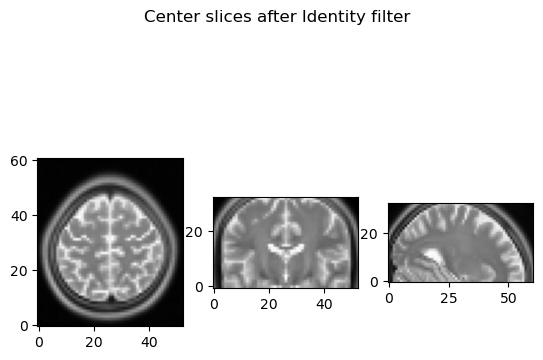

In [ ]:
# This is done as a sanity check (to check our implementation is correct)

# We clear the memory buffer (set entire output image to zero), so that previous results do not interfere
filtered_image.fill(0.0)

duration_identity = run_filter(filter1, num_workers=mp.cpu_count(), chunks_per_worker=3)
print(f"Identity. Duration: {duration_identity:.3f}s")

# With this line, we check the correctness of the filter (the output matches the input)
identity = np.allclose(filtered_image, epi_img_data_final)
print("Identity produces identical output:", identity)

# We visualize center slices of the output. As the identity filter is used, these should look like the input image slices.
slice_0 = filtered_image[ min(26, Z-1), :, :]
slice_1 = filtered_image[ :, min(30, Y-1), :]
slice_2 = filtered_image[ :, :, min(16, X-1)]
show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices after Identity filter")
plt.show()


Run the filters and visualize the results:

Edge XY. Duration: 2.361s


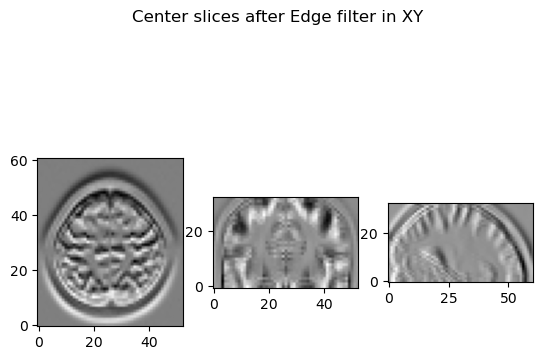

Edge XZ. Duration: 2.255s


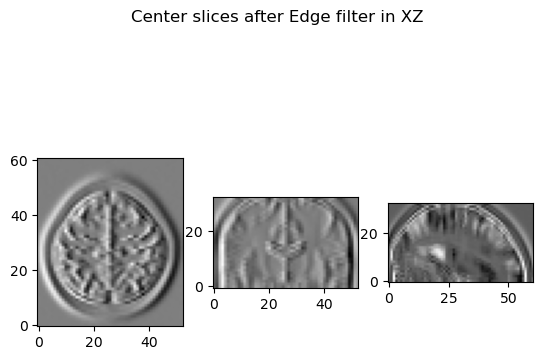

In [59]:

# Filter2: XY edges 
filtered_image.fill(0.0)
duration_xy = run_filter(filter2, num_workers=mp.cpu_count(), chunks_per_worker=3)
print(f"Edge XY. Duration: {duration_xy:.3f}s")

slice_0 = filtered_image[ min(26, Z-1), :, :]
slice_1 = filtered_image[ :, min(30, Y-1), :]
slice_2 = filtered_image[ :, :, min(16, X-1)]
show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices after Edge filter in XY")
plt.show()

# Filter3: XZ edges 
filtered_image.fill(0.0)
duration_xz = run_filter(filter3, num_workers=mp.cpu_count(), chunks_per_worker=3)
print(f"Edge XZ. Duration: {duration_xz:.3f}s")

slice_0 = filtered_image[ min(26, Z-1), :, :]
slice_1 = filtered_image[ :, min(30, Y-1), :]
slice_2 = filtered_image[ :, :, min(16, X-1)]
show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices after Edge filter in XZ")
plt.show()


*NOTE* The follow code fetch from the stack the exectution statistics produced by the magic metacommand %%timeit and stores it in a python variable.

RESULTS FOR FIRST FILTER

In [47]:
%%timeit -o
filtered_image.fill(0.0)
run_filter(filter1, num_workers=4)




1.02 s ± 35.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 1.02 s ± 35.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [48]:
statistics = _
print("Best execution time: {}".format(statistics.best))
print("Worst execution time: {}".format(statistics.worst))
print("Mean execution time: {mean} ({stdev} std dev)".format(mean=statistics.average,stdev=statistics.stdev))

Best execution time: 0.9689860999351367
Worst execution time: 1.096895599970594
Mean execution time: 1.0177327000170149 (0.03590223181680877 std dev)


SECOND FILTER

In [49]:
%%timeit -o
filtered_image.fill(0.0)
run_filter(filter2, num_workers=4)

1.01 s ± 48.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 1.01 s ± 48.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [50]:
statistics = _
print("Best execution time: {}".format(statistics.best))
print("Worst execution time: {}".format(statistics.worst))
print("Mean execution time: {mean} ({stdev} std dev)".format(mean=statistics.average,stdev=statistics.stdev))

Best execution time: 0.9570503999711946
Worst execution time: 1.0848456000676379
Mean execution time: 1.0130536142803197 (0.04868185853073784 std dev)


THIRD FILTER

In [51]:
%%timeit -o
filtered_image.fill(0.0)
run_filter(filter3, num_workers=4)

1.01 s ± 46.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 1.01 s ± 46.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [52]:
statistics = _
print("Best execution time: {}".format(statistics.best))
print("Worst execution time: {}".format(statistics.worst))
print("Mean execution time: {mean} ({stdev} std dev)".format(mean=statistics.average,stdev=statistics.stdev))

Best execution time: 0.9620643999660388
Worst execution time: 1.1079029999673367
Mean execution time: 1.0144383000110142 (0.04630445840051811 std dev)


* We see that all three filters take almost the same time to work properly. This was expected, as all filters perform the same number of operations.
The only thing changing between them is the numerical output.

# CONCLUSIONS

Javier's Conclusion:

This practical work allowed me to understand in depth how parallel processing can be applied to 3D image filtering. In this case, the dataset to filter was a medical MRI scan, which made the work meaningful, demonstrating its usefulness in a real-world context.

Although the filtering function was already provided, the task was to parallelize its execution efficiently and to manage the edges of the image correctly so that the filtering would remain consistent across the entire MRI. 
Handling the boundaries not seemed very important to me at first, but after having finished the project I have realized it is an esential process, as it prevents the program to crash when trying to access invalid indices or to produce incorrect outputs in which the borders are distorted.

In the practical work we divided the dataset along one axis, assigning independent slices of this axis to different processes. This allowed all of them to use the same shared memory space without conflicts. It also allowed to cover the entire set of pixels in the image by easily iterating through the other two axes. This has taught me the importance of thinking about communication between processes to avoid conflicts.

This work has also showed me how shared memory and task partitioning help to improve the computational efficiency of the process.

I also learned to use the identity filter as a validation tool, which I found very useful to easily check the correctness of our code.

Overall, this project has been truly useful because it is a mix of theoretical concepts like convolution, boundary conditions and real computational challenges, such as multiprocessing synchronization and memory management. It has helped me develop a clearer understanding of how large-scale image processing is handled in practice.